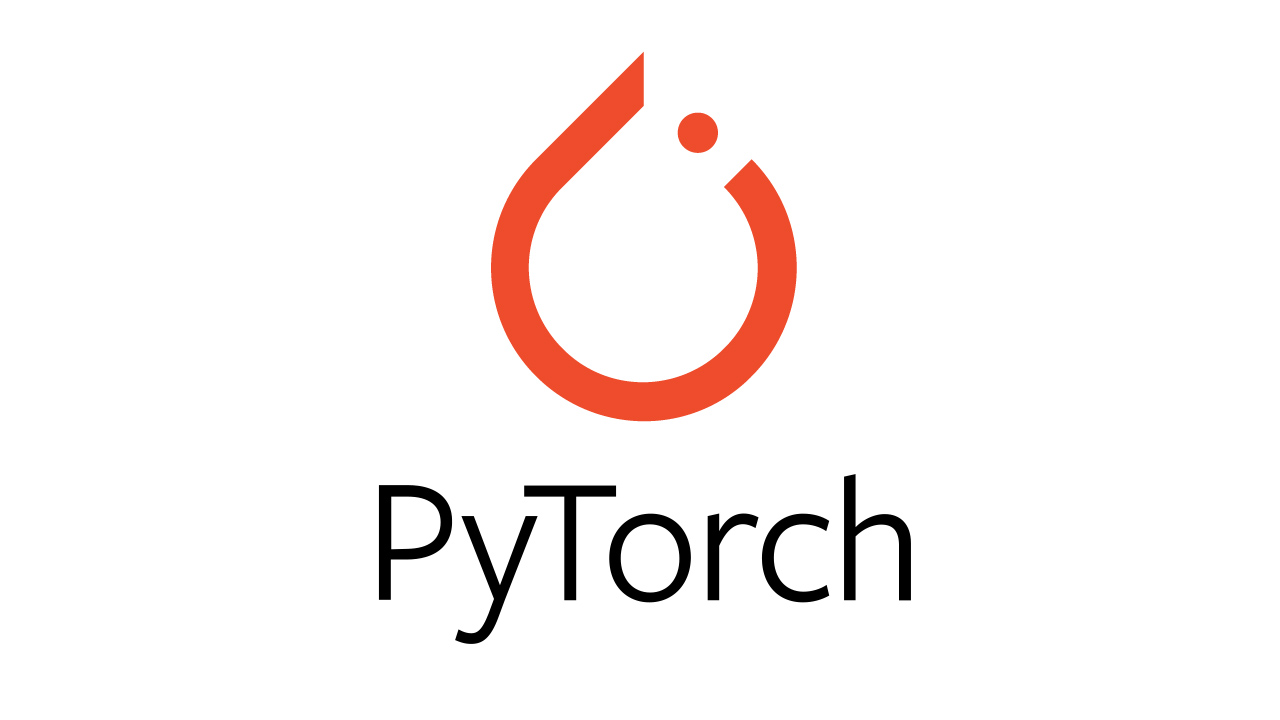

In [4]:
# Libraries

import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as functional
import torch.optim as optim
import torchvision as tv
import torchvision.transforms as transforms

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Firstly, it converts the image into a PyTorch tensor and scales pixel values to the range [0, 1]. Secondly, normalizes the tensor by subtracting the mean (0.5, 0.5, 0.5) and dividing by the standard deviation (0.5, 0.5, 0.5) for each RGB channel.

In [6]:
train_data = tv.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = tv.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:01<00:00, 106MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


It loads the CIFAR-10 dataset, splitting it into training (train=True) and testing (train=False) sets, and applies the specified transformations to the images.

In [7]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True, num_workers = 2)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = 64, shuffle = False, num_workers = 2)

In [8]:
image, label = train_data[0]
print(image.size())

torch.Size([3, 32, 32])


Each loader processes 64 images per batch. The training data is shuffled for randomness, while the testing data remains ordered. Two worker processes are used to load data efficiently

In [9]:
cifar10 = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 12 , 5) #output (12, 28, 28)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 24, 5) #output (24, 24, 24)
        self.fc1 = nn.Linear(24 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(functional.relu(self.conv1(x)))
        x = self.pool(functional.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = functional.relu(self.fc1(x))
        x = functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

- **"conv1"**;
    - *Input*: 3 channels.
    - *Output*: 12 feature maps with a kernel size of 5x5.
    - *Output size will be (12, 28, 28) (after applying the convolution).*
  
- **MaxPool2d(2, 2)**;
Reduces spatial dimensions by half using a 2x2 window. For instance, (12, 28, 28) → (12, 14, 14) after pooling.

- **conv2** = nn.Conv2d(12, 24, 5) :
  - *Input*: 12 channels (from conv1).
  - *Output*: 24 feature maps with a kernel size of 5x5.

- **self.fc1**;
  - Flattens the feature maps into a 1D vector (24 * 5 * 5 = 600) and maps it to 120 neurons.
- **self.fc2**;
  - Maps 120 neurons to 84 neurons.
- **self.fc3**;
  - Maps 84 neurons to 10 output classes (CIFAR-10 classes).

2. ***Forward Pass*** (forward Method) :
Defines how data flows through the network during inference or training.

  a) **Convolution + ReLU + Pooling**: Applies convolution (conv1), ReLU activation, and max pooling.Then, applies the second convolution (conv2), ReLU activation, and max pooling.
  b) Flattens the 3D feature maps into a 1D vector for input to fully connected layers.
  c) Applies ReLU activation to the first fully connected layer. After, applies ReLU activation to the second fully connected layer.
  d) Return: the final output (x) contains the logits for each class.

In [11]:
cnn = CNN()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr = 0.001, momentum = 0.9)

Code initializes the CNN model, sets up the CrossEntropyLoss function for multi-class classification, and configures the SGD optimizer with a learning rate of 0.001 and momentum of 0.9 to update the model's weights during training.

In [15]:
for epoch in range(12):

  print(f"Epoch {epoch}")
  running_loss = 0.0

  for i, data in enumerate(train_loader):
    inputs, labels = data
    optimizer.zero_grad()
    outputs = cnn(inputs)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  print(f'loss: {running_loss / len(train_loader):.4f}')

Epoch 0
loss: 1.3526
Epoch 1
loss: 1.3009
Epoch 2
loss: 1.2534
Epoch 3
loss: 1.2092
Epoch 4
loss: 1.1704
Epoch 5
loss: 1.1334
Epoch 6
loss: 1.1042
Epoch 7
loss: 1.0686
Epoch 8
loss: 1.0413
Epoch 9
loss: 1.0154
Epoch 10
loss: 0.9845
Epoch 11
loss: 0.9596


Code trains the CNN for 12 epochs, processing mini-batches of data in each epoch. It computes the loss, performs backpropagation, updates model weights, and prints the average loss per epoch

In [17]:
torch.save(cnn.state_dict(), 'train_cnn.pth')

cnn = CNN()
cnn.load_state_dict(torch.load('train_cnn.pth'))

<ipython-input-17-60cdb414c9f6>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load('train_cnn.pth'))


<All keys matched successfully>

It saves the trained model's weights to a file (train_cnn.pth) and later restores them by loading the weights into a new instance of the model.

In [19]:
correct, total = 0, 0

cnn.eval()
with torch.no_grad():
  for data in test_loader:
    images, labels = data
    outputs = cnn(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network: {100 * correct // total} %')

Accuracy of the network: 63 %


Code evaluates the CNN model on the test dataset, calculates the number of correct predictions, and computes the overall accuracy as a percentage.

In [31]:
new_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

def image(path):
  pic = Image.open(path)
  pic = new_transform(pic)
  pic = pic.unsqueeze(0)
  return pic

paths = ["/content/airplane.webp", "/content/dog.webp", "/content/cat.webp", "/content/ship.webp"]
actual_names = ["Airplane", "Dog", "Cat", "Ship"]
images = [image(path) for path in paths]

cnn.eval()
with torch.no_grad():
  for i, pic in enumerate(images):
    images, labels = data
    output = cnn(pic)
    _, predicted = torch.max(output, 1)

    print(f"Actual: {actual_names[i]}, Predicted: {cifar10[predicted.item()].capitalize()}")

Actual: Airplane, Predicted: Airplane
Actual: Dog, Predicted: Dog
Actual: Cat, Predicted: Cat
Actual: Ship, Predicted: Ship


Code preprocesses custom images, passes them through a trained CNN model for inference, and prints the actual names alongside the predicted labels.